## Neural networks for segmentation

Обновите библиотеку torchvision и **перезапустите Runtime**

In [1]:
!pip install torchvision==0.4.2

In [4]:
!pip install pillow==6.0.0

     |████████████████████████████████| 2.0MB 2.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [1]:
import PIL
PIL.__version__

'6.0.0'

In [1]:
import torchvision
torchvision.__version__

'0.4.2'

In [0]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

--2020-03-19 15:19:03--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2020-03-19 15:19:03--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc752c83e2edeb64a4c24f3f24e5.dl.dropboxusercontent.com/cd/0/inline/A0PxVxu0-RK-zH-qZdmngejtDqham4978ybv13W_ZMKuJgAqxAi0e_z44CeAWWZZrhZhTi2E4v9GENjNCI3ltVxM1uQWKG3RSQncGQFj_cMXLw/file# [following]
--2020-03-19 15:19:03--  https://uc752c83e2edeb64a4c24f3f24e5.dl.dropboxusercontent.com/cd/0/inline/A0PxVxu0-RK-zH-qZdmngejtDqham4978ybv13W_ZMKuJgAqxAi0e_z44CeAWWZZrhZhTi2E4v9GENjNCI3ltVxM1uQWKG3RSQncGQFj_cMXLw/file
Resolving uc752c83e2edeb64

In [0]:
import matplotlib.pyplot as plt
import scipy.misc

In [0]:
from PIL import Image

FileNotFoundError: ignored

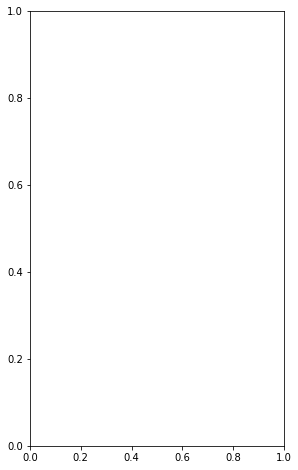

In [4]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = Image.open('images/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = Image.open('masks/train/00735-cells.png')
plt.imshow(mask, 'gray')

In [0]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [0]:
import os

import torch
import numpy as np
import torchvision
from torchvision import transforms

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data.dataset import Dataset
import random

In [0]:
import torchvision.transforms.functional as TF

class SegmentationDataset(Dataset):
    def __init__(self, image_paths=None, target_paths=None, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.train = train

    def transform(self, image, mask):
        # Resize
        if self.train:

            # Random vertical flipping
            if random.random() > 0.5:
                image = TF.vflip(image)
                # mask = YOUR CODE

            # Random rotate using TF.rotate(image, angle)
            
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = (TF.to_tensor(mask) > 0.01).type(torch.FloatTensor)
        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        if self.target_paths:
            mask = Image.open(self.target_paths[index][:-14] + '-cells.png')
        else:
            mask = Image.open(self.image_paths[index])
            x, y = self.transform(image, mask)
            return x, self.image_paths[index]
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.image_paths)

In [0]:
train_filenames = os.listdir('/content/BBBC018_v1_images-fixed/train')
train_images_path = ['/content/BBBC018_v1_images-fixed/train/' + fname for fname in train_filenames]
train_masks_path = ['/content/BBBC018_v1_outlines/train/' + fname for fname in train_filenames]

val_filenames = os.listdir('/content/BBBC018_v1_images-fixed/val')
val_images_path = ['/content/BBBC018_v1_images-fixed/val/' + fname for fname in val_filenames]
val_masks_path = ['/content/BBBC018_v1_outlines/val/' + fname for fname in val_filenames]

In [0]:
train_dataset = SegmentationDataset(image_paths=train_images_path, target_paths=train_masks_path, train=False)

In [0]:
val_dataset = SegmentationDataset(image_paths=val_images_path, target_paths=val_masks_path, train=False)

In [0]:
batch_size = 7
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True)

In [0]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True)

In [53]:
for x_batch, y_batch in train_batch_gen:
    print(x_batch.shape)

torch.Size([7, 3, 512, 512])
torch.Size([7, 3, 512, 512])
torch.Size([7, 3, 512, 512])
torch.Size([7, 3, 512, 512])
torch.Size([7, 3, 512, 512])
torch.Size([6, 3, 512, 512])


In [0]:
import itertools

In [0]:
class MyUnet(nn.Module):
    def __init__(self, filters):
        super(MyUnet, self).__init__()
        self.filters = filters

        encoder_layers = []
        in_filters = 3
        for i, ifilters in enumerate(filters):            
            encoder_layers.append(nn.ModuleList([
                nn.MaxPool2d(2),

                nn.Conv2d(in_filters, ifilters, kernel_size=3, padding=1),
                nn.BatchNorm2d(ifilters),
                nn.ReLU(),

                nn.Conv2d(ifilters, ifilters, kernel_size=3, padding=1),
                nn.BatchNorm2d(ifilters),
                nn.ReLU(),
            ]))
            in_filters = ifilters

        self.encoder_list = encoder_layers
        [self.add_module('encoder_' + str(i), layer) for i, layer in enumerate(list(itertools.chain(*self.encoder_list)))]

        decoder_layers = []
        for i in range(len(filters) - 1):
            print(i)
            print('filters ', -i -2,  '', filters[-i-2])
            decoder_layers.append(([
                nn.ConvTranspose2d(filters[-i - 1], filters[-i - 2], kernel_size=2, stride=2),
                nn.Conv2d(filters[-i - 1], filters[-i - 2], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[-i - 2]),
                nn.ReLU(),

                nn.Conv2d(filters[-i - 2], filters[-i - 2], kernel_size=3, padding=1),
                nn.BatchNorm2d(filters[-i - 2]),
                nn.ReLU()
                ]))
        decoder_layers.append(
            ([nn.ConvTranspose2d(filters[0], filters[0], kernel_size=2, stride=2)]))

        self.decoder_list = decoder_layers
        self.encoder_outputs = []
        [self.add_module('decoder_' + str(i), layer) for i, layer in enumerate(list(itertools.chain(*self.decoder_list)))]

        self.head_list = [nn.Conv2d(filters[0], 1, kernel_size=1), nn.Sigmoid()]
        [self.add_module('my_head' + str(i), layer) for i, layer in enumerate(self.head_list)]

    def encoder(self, x):
        output = x
        for i, block in enumerate(self.encoder_list):
            for j, layer in enumerate(block):
                output = layer(output)
            self.encoder_outputs.append(output)
        return output

    def decoder(self, x):
        output = x
        for i, block in enumerate(self.decoder_list[:-1]):
            upsampled_x = block[0](output)
            encoder_tensor = self.encoder_outputs[-i - 2]
            output = torch.cat([encoder_tensor, upsampled_x], 1)
            for j, layer in enumerate(block[1:]):
                output = layer(output)
        output = self.decoder_list[-1][0](output)
        return output

    def forward(self, x):
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(encoder_output)
        output = self.head_list[0](decoder_output)
        self.encoder_outputs = []
        return self.head_list[1](output)

In [0]:
my_filters = [10, 20, 40]

In [29]:
model = MyUnet(my_filters)

0
filters  -2  20
1
filters  -3  10


In [0]:
opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []

In [0]:
compute_loss = nn.BCELoss()

In [32]:
import time
num_epochs = 274
batch_size = 7

for epoch in range(num_epochs):
    start_time = time.time()
    model.train(True)
    for (X_batch, y_batch) in train_batch_gen:
        X_batch = torch.tensor(X_batch, dtype=torch.float32)
        y_batch = torch.tensor(y_batch, dtype=torch.float32)
        logits = model(X_batch)

        y_batch = y_batch.view(y_batch.size(0), -1)
        y_predicted = (logits.view(X_batch.size(0), -1))

        loss = compute_loss(y_predicted, y_batch)

        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss.append(loss.data.numpy())
    print (epoch)

    model.train(False)
    for X_batch, y_batch in val_batch_gen:

        logits = model(torch.FloatTensor(X_batch)).data.numpy()
        y_pred = (logits > 0.3).astype(np.float32)

        val_accuracy.append(calc_iou(y_pred, y_batch.numpy()))

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


0
Epoch 1 of 274 took 16.974s
  training loss (in-iteration): 	0.689048
  validation accuracy: 			5.29 %
1
Epoch 2 of 274 took 16.370s
  training loss (in-iteration): 	0.656348
  validation accuracy: 			5.29 %


KeyboardInterrupt: ignored

In [0]:
TRESHOLD = 0.3

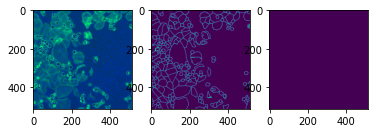

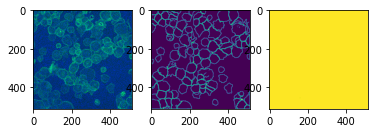

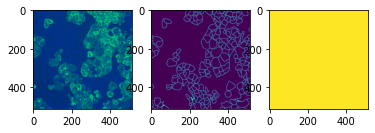

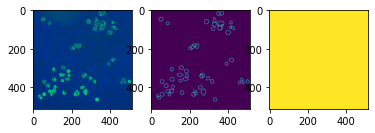

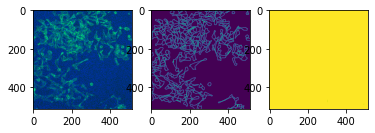

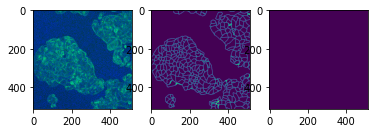

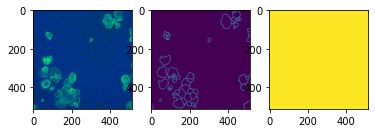

In [40]:
for X_batch, y_batch in val_batch_gen:
    logits = model(torch.FloatTensor(X_batch)).data.numpy()
    y_pred = (logits > TRESHOLD).astype(np.float32)
    for i in range(len(X_batch)):
      fig, ax = plt.subplots(1, 3)
      ax[0].imshow(X_batch[i, ...].T)
      ax[1].imshow(y_batch[i,...].T[..., 0])
      ax[2].imshow(y_pred[i, ...].T[..., 0])
      plt.show()


